In [1]:
import os, json, random, cv2
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf, re, math
from tqdm import tqdm

In [2]:
DATASET_NAME = f"happywhale-tfrecords-fullbody"

%%time

### Create Kaggle Dataset if not exists 

DATASET_NAME = f'happywhale-tfrecords-fullbody'

!rm -r /tmp/{DATASET_NAME}

os.makedirs(f'/tmp/{DATASET_NAME}', exist_ok=True)

with open('../input/kaggle-token/kaggle.json') as f:
    kaggle_creds = json.load(f)
    
os.environ['KAGGLE_USERNAME'] = kaggle_creds['username']
os.environ['KAGGLE_KEY'] = kaggle_creds['key']

!kaggle datasets init -p /tmp/{DATASET_NAME}


with open(f'/tmp/{DATASET_NAME}/dataset-metadata.json') as f:
    dataset_meta = json.load(f)
dataset_meta['id'] = f'AGEAGE/{DATASET_NAME}'
dataset_meta['title'] = DATASET_NAME
with open(f'/tmp/{DATASET_NAME}/dataset-metadata.json', "w") as outfile:
    json.dump(dataset_meta, outfile)
print(dataset_meta)

!cp /tmp/{DATASET_NAME}/dataset-metadata.json /tmp/{DATASET_NAME}/meta.json
!ls /tmp/{DATASET_NAME}

!kaggle datasets create -u -p /tmp/{DATASET_NAME} 


In [ ]:
## check crop image

In [3]:
import cv2, os

files = os.listdir("../../data/fullbody/train_crop/")

for i in files:
    img = cv2.imread("../../data/fullbody/train_crop/" + i)
    try:
        x, y, z = img.shape
    except:
        print(i)

In [2]:
train_df = pd.read_csv("../../data/happywhale-splits/skf_species_10folds.csv")
test_df = pd.read_csv("../../data/happy-whale-and-dolphin/sample_submission.csv")
test_df["split"] = test_df.index % 10
train_df.agg(["min", "max", "count", "nunique"])

,image,species,individual_id,fold
min,00021adfb725ed.jpg,0,0,0.0
max,fffdcd42312777.jpg,29,15586,9.0
count,51033,51033,51033,51033.0
nunique,51033,30,15587,10.0


In [3]:
def get_fold(fold):
    val_df = train_df[train_df.fold == fold].reset_index(drop=True)
    val_df["order"] = val_df.index
    val_df["order"] = val_df.groupby("individual_id").order.rank()
    val_total_counts = val_df.individual_id.value_counts().to_dict()
    val_df["total_counts"] = val_df.individual_id.map(val_total_counts)
    val_df["order"] = val_df["order"] / val_df["total_counts"]
    val_df = val_df.sort_values("order", ascending=False).reset_index(drop=True)
    val_df = val_df[["image", "species", "individual_id"]]
    return val_df

In [4]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def serialize_example(image, image_name, target, species):
    feature = {
        "image": _bytes_feature(image),
        "image_name": _bytes_feature(image_name),
        "target": _int64_feature(target),
        "species": _int64_feature(species),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [5]:
def create_tf_records(fold=0):
    df = get_fold(fold)
    tfr_filename = (
        f"../../data/tfrec/fullbody/happywhale-2022-train-{fold}-{df.shape[0]}.tfrec"
    )
    with tf.io.TFRecordWriter(tfr_filename) as writer:
        for i, row in df.iterrows():
            image_id = row.image
            target = row.individual_id
            species = row.species
            image_path = f"../../data/fullbody/train_crop/{image_id}"
            image_encoded = tf.io.read_file(image_path)
            image_name = str.encode(image_id)
            example = serialize_example(image_encoded, image_name, target, species)
            writer.write(example)

!ls /tmp/happywhale-tfrecords-fullbody

In [6]:
import joblib

_ = joblib.Parallel(n_jobs=2)(
    joblib.delayed(create_tf_records)(fold) for fold in tqdm(range(10))
)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:08<00:00, 66.85s/it]


In [12]:
def create_test_tf_records(fold=0):
    df = test_df[test_df.split == fold]
    tfr_filename = (
        f"../../data/tfrec/fullbody/happywhale-2022-test-{fold}-{df.shape[0]}.tfrec"
    )
    with tf.io.TFRecordWriter(tfr_filename) as writer:
        for i, row in df.iterrows():
            image_id = row.image
            target = -1
            species = -1
            image_path = f"../../data/fullbody/test_crop/{image_id}"
            image_encoded = tf.io.read_file(image_path)
            image_name = str.encode(image_id)
            example = serialize_example(image_encoded, image_name, target, species)
            writer.write(example)

In [13]:
import joblib

_ = joblib.Parallel(n_jobs=2)(
    joblib.delayed(create_test_tf_records)(fold) for fold in tqdm(range(10))
)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [10:55<00:00, 65.57s/it]


from datetime import datetime
version_name = datetime.now().strftime("%Y%m%d-%H%M%S")
print(version_name)

!ls /tmp/{DATASET_NAME}

!kaggle datasets version -m {version_name} -p /tmp/{DATASET_NAME} -r zip -q

## Verify TFRecords

In [7]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = (
        tf.cast(image, tf.float32) / 255.0
    )  # convert image to floats in [0, 1] range
    image = tf.image.resize(image, IMAGE_SIZE_)
    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature(
            [], tf.string
        ),  # shape [] means single element
        "target": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    label = example["target"]
    return image, label  # returns a dataset of (image, label) pairs


def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # disable order, increase speed

    dataset = tf.data.TFRecordDataset(
        filenames, num_parallel_reads=AUTO
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset


def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.repeat()  # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(
        AUTO
    )  # prefetch next batch while training (autotune prefetch buffer size)
    return dataset


def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [
        int(re.compile(r"-([0-9]*)\.").search(filename).group(1))
        for filename in filenames
    ]
    return np.sum(n)

In [8]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)
CLASSES = [0, 1]


def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    # if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
    #    numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels


def display_single_sample(image, label, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis("off")
    plt.imshow(image)
    title = str(label)
    if len(title) > 0:
        plt.title(
            title,
            fontsize=int(titlesize) if not red else int(titlesize / 1.2),
            color="red" if red else "black",
            fontdict={"verticalalignment": "center"},
            pad=int(titlesize / 1.5),
        )
    return (subplot[0], subplot[1], subplot[2] + 1)


def display_batch_of_images(databatch):
    """
    Display single batch Of images
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]

    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows

    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot = (rows, cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE, FIGSIZE / cols * rows))
    else:
        plt.figure(figsize=(FIGSIZE / rows * cols, FIGSIZE))

    # display
    for i, (image, label) in enumerate(
        zip(images[: rows * cols], labels[: rows * cols])
    ):
        correct = True
        dynamic_titlesize = (
            FIGSIZE * SPACING / max(rows, cols) * 40 + 3
        )  # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_single_sample(
            image, label, subplot, not correct, titlesize=dynamic_titlesize
        )

    # layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [9]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

10
51033


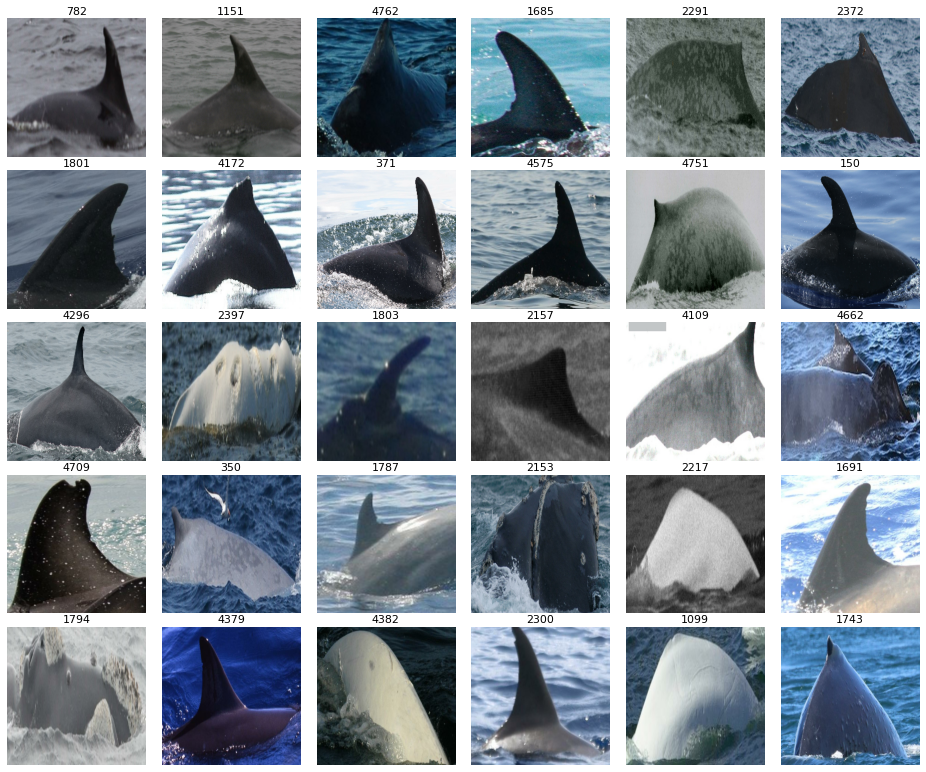

In [10]:
IMAGE_SIZE_ = [IMAGE_SIZE, IMAGE_SIZE]
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob(
    f"../../data/tfrec/fullbody/happywhale-2022-train*.tfrec"
)
print(len(TRAINING_FILENAMES))
dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
dataset = dataset.repeat()
dataset = dataset.shuffle(2048)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(
    AUTO
)  # This dataset can directly be passed to keras.fit method
print(count_data_items(TRAINING_FILENAMES))

# Displaying single batch of TFRecord
train_batch = iter(dataset)
display_batch_of_images(next(train_batch))

In [11]:
for i in tqdm(range(51033 // BATCH_SIZE)):
    _ = next(train_batch)

100%|██████████████████████████████████████████████████████████████████████████████| 1594/1594 [09:51<00:00,  2.70it/s]


10
27956


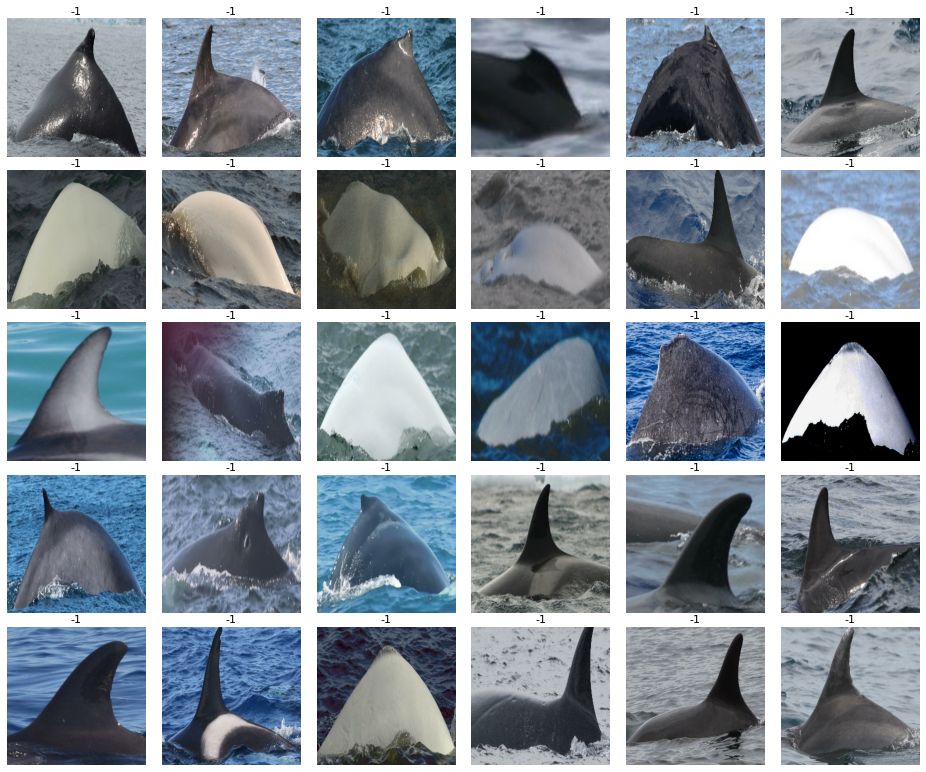

In [14]:
IMAGE_SIZE_ = [IMAGE_SIZE, IMAGE_SIZE]
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob(
    f"../../data/tfrec/fullbody/happywhale-2022-test*.tfrec"
)
print(len(TRAINING_FILENAMES))
dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
dataset = dataset.repeat()
dataset = dataset.shuffle(2048)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(
    AUTO
)  # This dataset can directly be passed to keras.fit method
print(count_data_items(TRAINING_FILENAMES))

# Displaying single batch of TFRecord
train_batch = iter(dataset)
display_batch_of_images(next(train_batch))

In [15]:
for i in tqdm(range(27956 // BATCH_SIZE)):
    _ = next(train_batch)

100%|████████████████████████████████████████████████████████████████████████████████| 873/873 [05:56<00:00,  2.45it/s]
